In [1]:
!pip install -q matplotlib numpy scipy pandas seaborn networkx shapely


[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [170]:
import functools
import matplotlib.pyplot as plt
import matplotlib.collections as mpc
import numpy as np
import scipy.stats as scs
from scipy.fft import dctn, idctn
import scipy.optimize as sco
import pandas as pd
import seaborn as sns
import copy
plt.rcParams.update(plt.rcParamsDefault)
sns.set_style("whitegrid")
from shapely.geometry import LineString, Point

## Distributions

In [3]:
# Fitted to Perkins et al. 2011 scaled by Gast et al. 2019
df_perkins_raw = pd.DataFrame({"Time": np.array([.2,.7,1.5,2.4,3.0,4.1,5.0,6.1,9.5,510])/3.87, "Percentage":[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]})
df_perkins_raw = df_perkins_raw.assign(Source= lambda _: "Perkins et al. 2011", Type= lambda _:"Raw")

t = np.linspace(0,df_perkins_raw.Time.max(), 1000)
def fn(x, s,loc, scale):
    return scs.lognorm.cdf(x,s, loc, scale)

args, cov = sco.curve_fit(fn,df_perkins_raw.Time,df_perkins_raw.Percentage)

df_perkins_fitted = pd.DataFrame({"Time": t, "Percentage":scs.lognorm.cdf(t, *args)})
df_perkins_fitted = df_perkins_fitted.assign(Source= lambda _: "Perkins et al. 2011", Type= lambda _:"Fitted")

args

array([ 0.53454097, -0.78181498,  1.57007452])

In [4]:
# Fitted to Koester 2008
p = scs.lognorm(0.3318411053416274, -10.954538833617004, 13.781658879455453)

df_koester_raw = pd.DataFrame({"Time": [0,3,6,14], "Percentage":[0.25, 0.5, 0.75, 0.95]})
df_koester_raw = df_koester_raw.assign(Source= lambda _: "Koester 2008", Type= lambda _:"Raw")

df_koester_fitted = pd.DataFrame({"Time": t, "Percentage":p.cdf(t)})
df_koester_fitted = df_koester_fitted.assign(Source= lambda _: "Koester 2008", Type= lambda _:"Fitted")

In [5]:
df = pd.concat([df_koester_raw, df_koester_fitted, df_perkins_fitted, df_perkins_raw])
df.reset_index(inplace=True)
df.Percentage *= 100
df.rename(columns={"Percentage":"Cumulative Percentage"}, inplace=True)
df

index        Time  Cumulative Percentage               Source    Type
0         0    0.000000               25.00000         Koester 2008     Raw
1         1    3.000000               50.00000         Koester 2008     Raw
2         2    6.000000               75.00000         Koester 2008     Raw
3         3   14.000000               95.00000         Koester 2008     Raw
4         0    0.000000               24.45153         Koester 2008  Fitted
...     ...         ...                    ...                  ...     ...
2009      5    1.059432               60.00000  Perkins et al. 2011     Raw
2010      6    1.291990               70.00000  Perkins et al. 2011     Raw
2011      7    1.576227               80.00000  Perkins et al. 2011     Raw
2012      8    2.454780               90.00000  Perkins et al. 2011     Raw
2013      9  131.782946              100.00000  Perkins et al. 2011     Raw

[2014 rows x 5 columns]

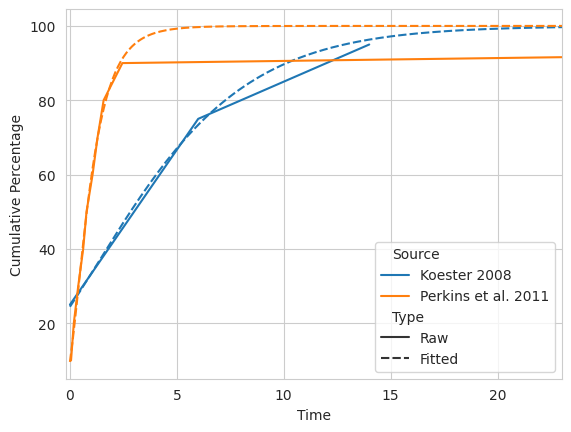

In [6]:
fig,ax = plt.subplots()
sns.lineplot(data=df, x="Time", y="Cumulative Percentage", hue="Source", style="Type", ax=ax)
ax.set_xlim([-0.2,23])

plt.show()
fig.savefig("fitted_mobility_hiker.pdf")

In [7]:
def get_path(a, b, N=100):

    z = np.linspace(0,1000,N)

    x,y = np.random.randint(0,1000,size=(2,N)).astype(float)
    
    x += z*a
    y += z*b
            
    x[0] = 0
    y[0] = 0

    xy_dctn = dctn([x,y])
    xy_dctn[:,N//10:] = 0
    return idctn(xy_dctn).T.reshape((-1,2))

In [8]:
N = 30
M = 1000
paths = [get_path(*(1.5+2*(np.random.rand(2)-0.5))) for _ in range(N)]
linestrings = [LineString(p) for p in paths]

maxdist = max(linestrings, key=lambda l: l.length).length
speed = 120

multipoints = []
for line in linestrings:
    points = []
    sample = speed*p.rvs(M)
    for dist in sample:
        if dist>0 and dist<maxdist:
            points.append(line.interpolate(dist).coords)
    
    
    points = np.array(points).reshape((-1,2))
    multipoints.append(points)

In [9]:
df = pd.DataFrame([], columns=["x","y","type","line_id"])

for i in np.arange(0,len(multipoints), len(multipoints)//2):
    x,y = linestrings[i].xy
    n = multipoints[i].shape[0]//20

    index = df.index.max()
    if np.isnan(index):
        index= np.arange(0, len(x))
    else:
        index = np.arange(index+1, index+len(x)+1)
    df = pd.concat(
        [df, pd.DataFrame(
            {"x":x,"y":y, "type":"line", "line_id":i},index=index
        )])

    index = np.arange(df.index.max()+1, df.index.max()+len(multipoints[i][::n,1])+1)
    df = pd.concat(
        [df,
         pd.DataFrame(
             {"x":multipoints[i][::n,0],"y":multipoints[i][::n,1], "type":"point", "line_id":i},index=index
         )
        ])

df.reindex()
df.sort_index(inplace=True)
df

x           y   type line_id
0    662.792739  497.516365   line       0
1    660.612996  498.443007   line       0
2    656.397654  500.260257   line       0
3    650.424355  502.901687   line       0
4    643.083780  506.281217   line       0
..          ...         ...    ...     ...
237  600.765157  572.332459  point      15
238  687.495508  538.996118  point      15
239  786.724908  896.937543  point      15
240  844.456375  512.084771  point      15
241  653.464704  551.384578  point      15

[242 rows x 4 columns]

In [10]:
fig,ax = plt.subplots()
sns.set_theme()
# sns.lineplot(data=df,x="x",y="y",hue="line_id", sort=False ,ax=ax)
for id_ in df.line_id.unique():
    line_df = df[(df.line_id==id_)&(df.type=="line")]
    line = ax.plot(line_df.x, line_df.y)

    point_df = df[(df.line_id==id_)&(df.type=="point")]
    c = line[0].get_color()
    ax.scatter(point_df.x, point_df.y, color=c)
    ax.scatter(line_df.x.iloc[0], line_df.y.iloc[0],80,marker='X',label="Start", color=c)
    ax.scatter(line_df.x.iloc[-1], line_df.y.iloc[-1],80,marker='*',label="End", color=c)

handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(h) for h in handles]
for h in handles:
    h.set_facecolor("black")
    h.set_edgecolor("black")
by_label = dict(zip(labels, handles))

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(by_label.values(), by_label.keys())
plt.show()
fig.savefig('sampling_along_path.pdf')

In [11]:
fig, ax = plt.subplots()
sns.set_style()
    
heatmap, xedges, yedges = np.histogram2d(np.vstack(multipoints)[:,0], np.vstack(multipoints)[:,1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

ax.imshow(heatmap.T, extent=extent, origin='lower')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([xedges[0],2000])
ax.set_ylim([yedges[0],2000])
fig.tight_layout()
plt.show()
fig.savefig('sampling_along_path_heatmap.pdf')

## Viewshed Weights


In [12]:
labels = [
"Woodland",
"Arable and horticulture",
"Improved grassland",
"Neutral grassland",
"Calcareous grassland",
"Acid grassland",
"Fen, March, Swamp",
"Heather",
"Heather grassland",
"Bog",
"Water",
"Rock",
"Saltmarsh",
"Urban"
]

building_feature_follow_values = \
    [0.2,0.25,0.05,0.1,0.05,0.05,0.03,0.06,0.05,0.01,0.2,0.05,0.05,0.4]
tree_follow_values = \
    [0.4,0.25,0.05,0.1,0.05,0.05,0.03,0.06,0.05,0.01,0.2,0.05,0.05,0.2]
water_follow_values = \
    [0.2,0.25,0.05,0.1,0.05,0.05,0.03,0.06,0.05,0.01,0.4,0.05,0.05,0.2]

df = pd.concat([
    pd.DataFrame({"Value":building_feature_follow_values,"Label":labels,"Type":"Building"}),
    pd.DataFrame({"Value":tree_follow_values,"Label":labels,"Type":"Tree"}),
    pd.DataFrame({"Value":water_follow_values,"Label":labels,"Type":"Water"}),
])
df

Value                    Label      Type
0    0.20                 Woodland  Building
1    0.25  Arable and horticulture  Building
2    0.05       Improved grassland  Building
3    0.10        Neutral grassland  Building
4    0.05     Calcareous grassland  Building
5    0.05           Acid grassland  Building
6    0.03        Fen, March, Swamp  Building
7    0.06                  Heather  Building
8    0.05        Heather grassland  Building
9    0.01                      Bog  Building
10   0.20                    Water  Building
11   0.05                     Rock  Building
12   0.05                Saltmarsh  Building
13   0.40                    Urban  Building
0    0.40                 Woodland      Tree
1    0.25  Arable and horticulture      Tree
2    0.05       Improved grassland      Tree
3    0.10        Neutral grassland      Tree
4    0.05     Calcareous grassland      Tree
5    0.05           Acid grassland      Tree
6    0.03        Fen, March, Swamp      Tree
7    0.06                  Heather      Tree
8    0.05        Heather grassland      Tree
9    0.01                      Bog      Tree
10   0.20                    Water      Tree
11   0.05                     Rock      Tree
12   0.05                Saltmarsh      Tree
13   0.20                    Urban      Tree
0    0.20                 Woodland     Water
1    0.25  Arable and horticulture     Water
2    0.05       Improved grassland     Water
3    0.10        Neutral grassland     Water
4    0.05     Calcareous grassland     Water
5    0.05           Acid grassland     Water
6    0.03        Fen, March, Swamp     Water
7    0.06                  Heather     Water
8    0.05        Heather grassland     Water
9    0.01                      Bog     Water
10   0.40                    Water     Water
11   0.05                     Rock     Water
12   0.05                Saltmarsh     Water
13   0.20                    Urban     Water

In [13]:
fig, ax = plt.subplots()
g = sns.barplot(data=df, y="Label", x="Value",hue="Type",ax=ax)
g.set(ylabel=None)
g.axes.get_legend().set_title("Head to")
fig.tight_layout()
plt.show()
fig.savefig('lcid_viewshed_weights.pdf')

## Viewshed Example

In [14]:
from scipy.interpolate import griddata
from scipy.spatial import Voronoi, voronoi_plot_2d

In [15]:
x,y = np.meshgrid(np.arange(10), np.arange(10))

z = np.sin(x+y) + 1

# Hand made viewshed
z_vis_mask = ~((x+y<14)&(x+y>8))

z_lcid = np.ones(z.shape)
z_lcid[(x>=5)&(y>=5)] = 2
z_lcid[(x<5)&(y<5)] = 3
z_lcid[(x<5)&(y>=5)] = 6
z_lcid[((x+y<14)&(x+y>6)&(-y+x>1))] = 4
z_lcid[((x+y<14)&(x+y>6)&(y-x>3))] = 5

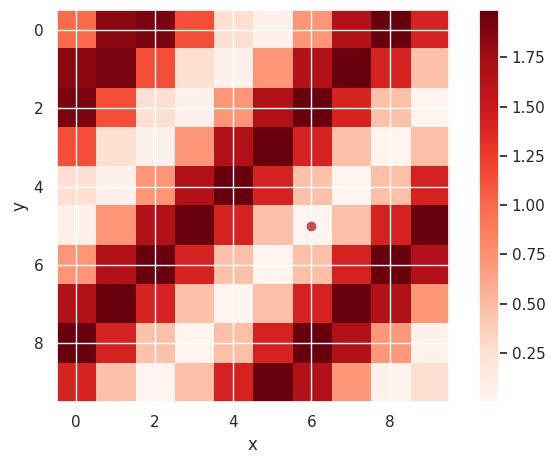

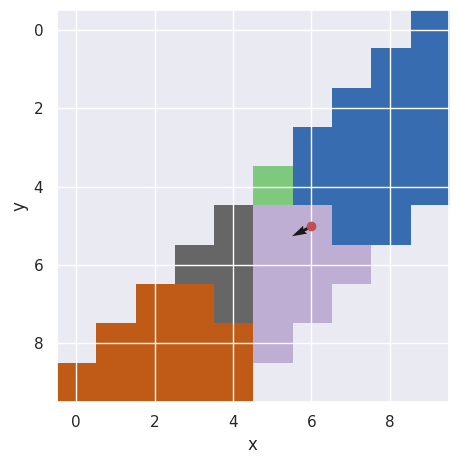

In [16]:
def set_common(ax, fig):
    ax.scatter(6,5,c='r')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.tight_layout()
    
fig, ax = plt.subplots(1,1)
ax1 = ax.imshow(z,cmap=plt.cm.Reds)
set_common(ax, fig)
fig.colorbar(ax1)
plt.show()

fig, ax = plt.subplots(1,1)
ax.imshow(z_lcid, cmap=plt.cm.Accent)
set_common(ax, fig)
plt.show()

fig, ax = plt.subplots(1,1)
ax.imshow(np.ma.masked_array(z_lcid, z_vis_mask),cmap=plt.cm.Accent)
ax.quiver(6,5,-2,-1)
set_common(ax, fig)
plt.show()

## Path Network Traversal

In [166]:
import networkx as nx

$$
\begin{align}
x(T) &= a T^2 + b T + c\\
\dot x(T) &= 2 a T + b\\
x(T=0) &= x_1 = c\\
x(T=t_f) &= x_2 = a t_f^2 + b t_f + c\\
\dot x(T=0) &= \dot x_1 = b\\
\dot x(T=t_f) &= \dot x_2 = 2 a t_f + b\\
\end{align}
$$

In [297]:
def poly_coeffs(x1, x2, v1=(0,0), v2=(0,0), t=1):
    A = np.array([
        [0,0,0,1],
        [t**3, t**2, t, 1],
        [0,0,1,0],
        [3*t, 2*t, 1, 0]
    ])

    b = np.row_stack(
        [x1,x2,v1,v2]
    )
    
    x_coeffs = np.linalg.solve(A,b[:,0])
    y_coeffs = np.linalg.solve(A,b[:,1])
    
    assert np.allclose(np.dot(A, x_coeffs), b[:,0])
    assert np.allclose(np.dot(A, y_coeffs), b[:,1])
    
    return x_coeffs,y_coeffs

def generate_path(x1, x2, v1=None, v2=None,t=1):
    
    if v1 is None:
        v1 = 3*(np.random.rand(2)-0.5)*2
    if v2 is None:
        v2 = 3*(np.random.rand(2)-0.5)*2
        
    
    cx, cy = poly_coeffs(x1,x2,v1,v2, t=t)
    t = np.linspace(0,1)
    
    x = cx[0]*t**3+cx[1]*t**2+cx[2]*t+cx[3]
    y = cy[0]*t**3+cy[1]*t**2+cy[2]*t+cy[3]
    
    return LineString(np.column_stack((x,y)))

In [298]:
nodes = [(0,1), (7,7), (4,1), (3,4), (10,10),(1,8),(10,0)]
edges = [(0,3),(1,4),(2,3),(6,5),(6,1),(6,2),(4,5),(3,5),(4,6),(5,1),(0,2)]

In [299]:
g = nx.Graph()
for v,w in edges:
    x1,x2 = nodes[v], nodes[w]
    g.add_edge(x1,x2, path=generate_path(x1,x2))

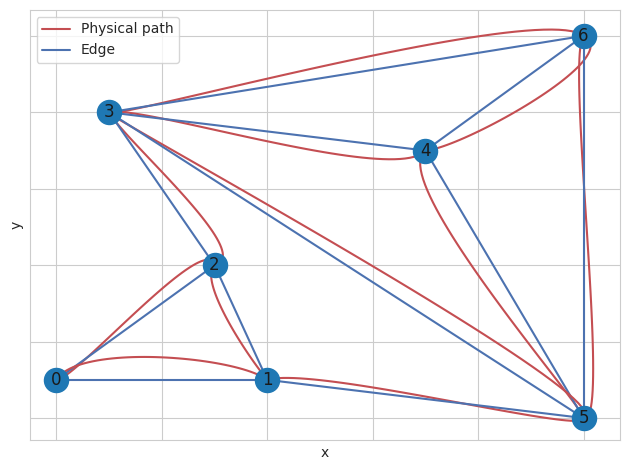

In [300]:
fig, ax  = plt.subplots()

nodes = sorted(list(g.nodes),key=lambda v: np.linalg.norm(v))

coords = {
    f:f for f in nodes
}
inds = {f:i for i,f in enumerate(nodes)}

for edge in g.edges:
    u,v = edge
    data = g.get_edge_data(u,v)
    path = data['path']
    p = ax.plot(path.coords.xy[0], path.coords.xy[1],c='r',label="Physical path")
    e = ax.plot([u[0], v[0]],[u[1],v[1]],c='b',label="Edge")
  
nx.draw_networkx_nodes(g,pos=coords,ax=ax)
nx.draw_networkx_labels(g,pos=coords,labels=inds)
ax.legend(handles=p+e)
ax.set_ylabel("y")
ax.set_xlabel("x")
fig.tight_layout()
plt.show()
fig.savefig('example_path_network.pdf')

## Weighted Nearest Angle

In [301]:
from shapely import ops

In [341]:
pos = Point(0,0)

roads = [
    [(0,.5),(0,1),(-1,-1),(-1,-1),3],
    [(0.5,0),(1,0.2),(-1,1),(0,0),2],
    [(0.5,1),(1,0.),(-1,-1),(-1,-1),1]
]

roads = [(generate_path(u,v,vu,vv),w) for u,v,vu,vv,w in roads]
roads = [(f,w,ops.nearest_points(pos,f)[1]) for f,w in roads]

In [342]:
roads

[(<LINESTRING (0 0.5, -0.019 0.481, -0.036 0.466, -0.05 0.455, -0.063 0.447, -...>,
  3,
  <POINT (-0.081 0.44)>),
 (<LINESTRING (0.5 0, 0.481 0.02, 0.465 0.039, 0.451 0.056, 0.441 0.073, 0.432...>,
  2,
  <POINT (0.423 0.114)>),
 (<LINESTRING (0.5 1, 0.481 0.98, 0.466 0.959, 0.455 0.939, 0.447 0.918, 0.442...>,
  1,
  <POINT (0.591 0.633)>)]

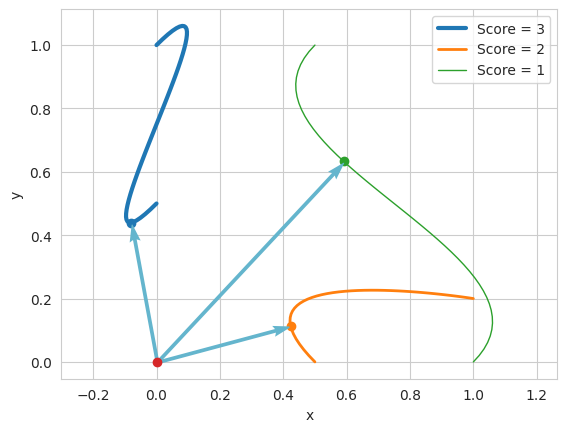

In [372]:
fig, ax  = plt.subplots()

for road in roads:
    ls,w,nearest = road
    a = ax.plot(ls.coords.xy[0], ls.coords.xy[1],linewidth=w,label=f"Score = {w}")
    b = ax.scatter(nearest.x,nearest.y)
    c = ax.quiver(pos.x,pos.y,nearest.x-pos.x,nearest.y-pos.y,scale=1,scale_units='xy',color='c')
    
ax.scatter(pos.x, pos.y)
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.axis('equal')
ax.legend()
plt.show()
fig.savefig("weighted_vec_paths.pdf")

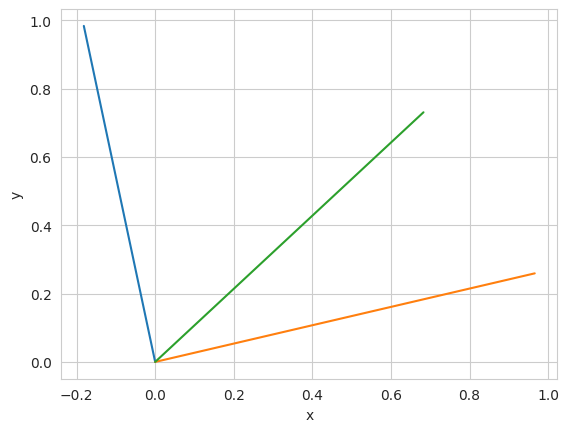

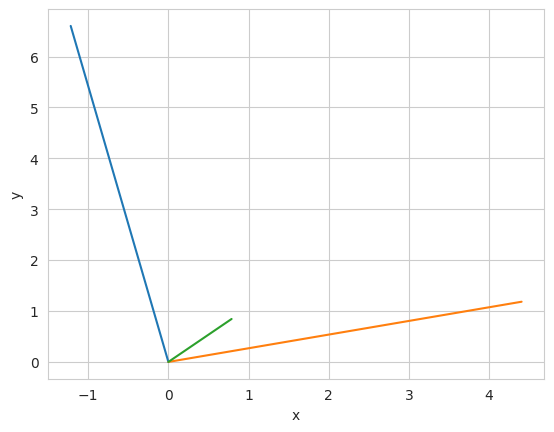

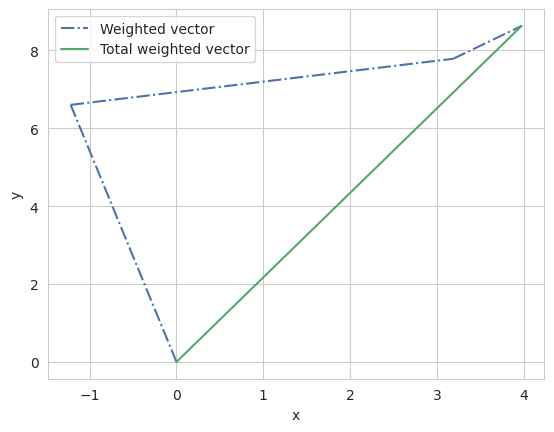

In [373]:
vecs = []
for _,weight,nearest in roads:
    dist = pos.distance(nearest)
    scale = weight/dist
    vec = np.array([nearest.x-pos.x,nearest.y-pos.y])
    vec /= np.linalg.norm(vec)
    vecs.append(scale*vec) 
    
fig, ax  = plt.subplots(1,1)
for vec in vecs:
    vec = vec.copy()
    vec /= np.linalg.norm(vec)
    ax.plot([pos.x,vec[0]],[pos.y,vec[1]])
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.show()
fig.savefig("unit_vec_angles.pdf")

fig, ax  = plt.subplots(1,1)
for vec in vecs:
    ax.plot([pos.x,vec[0]],[pos.y,vec[1]])
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.show()
fig.savefig("scaled_unit_vec_angles.pdf")

fig, ax  = plt.subplots(1,1)
prev = np.array([pos.x,pos.y])
c = prev.copy()
for vec in vecs:
    v = ax.plot([c[0],vec[0]+c[0]],[c[1],vec[1]+c[1]],'b-.',label="Weighted vector")
    c += vec
t= ax.plot([pos.x,c[0]],[pos.y,c[1]],'g',label="Total weighted vector")
ax.legend(handles=v+t)
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.show()
fig.savefig("total_weighted_vec_angles.pdf")